In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import SinkhornImputation_CMI
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\Student_performance_data _.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [4]:
ground_truth_numpy = scale(Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [5]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

2.3155349549638786
-2.0833445361659098
3.484620761622565e-17
-0.4318656463623108
1.0


In [6]:
print(ground_truth_numpy)

[[ 0.47291901  0.97849211 -0.85339088 ...  2.01954358 -0.43186565
   1.11808631]
 [ 1.36294441 -1.02198065 -0.85339088 ... -0.49516139 -0.43186565
   1.24237446]
 [-1.30713178 -1.02198065  1.09164102 ... -0.49516139 -0.43186565
  -1.96027719]
 ...
 [-0.41710638  0.97849211 -0.85339088 ... -0.49516139  2.31553495
  -0.83484487]
 [-0.41710638  0.97849211  0.11912507 ...  2.01954358 -0.43186565
  -0.11245195]
 [-0.41710638  0.97849211 -0.85339088 ... -0.49516139  2.31553495
   0.25555918]]


In [7]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(2392, 13)
tensor(0)


In [8]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.301


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 29.96%


In [9]:
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()

In [10]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
#epsilon_mcar30 = pick_epsilon(data_mcar30)
epsilon_mcar30 = 0.3
print(epsilon_mcar30)


0.3


In [11]:
sk_imputer_mcar30 = SinkhornImputation_CMI(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,sk_loss_mcar30 = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=50, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:Iteration 0:	 Loss: 2.7737	 Validation MAE: 0.8665	RMSE: 1.0027
INFO:root:Iteration 50:	 Loss: 2.9770	 Validation MAE: 0.8312	RMSE: 1.0024
INFO:root:Iteration 100:	 Loss: 2.9984	 Validation MAE: 0.8141	RMSE: 1.0028
INFO:root:Iteration 150:	 Loss: 2.7433	 Validation MAE: 0.8028	RMSE: 1.0039
INFO:root:Iteration 200:	 Loss: 2.8515	 Validation MAE: 0.7934	RMSE: 1.0040
INFO:root:Iteration 250:	 Loss: 2.8209	 Validation MAE: 0.7855	RMSE: 1.0036
INFO:root:Iteration 300:	 Loss: 3.0945	 Validation MAE: 0.7799	RMSE: 1.0042
INFO:root:Iteration 350:	 Loss: 2.7591	 Validation MAE: 0.7739	RMSE: 1.0039
INFO:root:Iteration 400:	 Loss: 2.6672	 Validation MAE: 0.7692	RMSE: 1.0040
INFO:root:Iteration 450:	 Loss: 2.7821	 Validation MAE: 0.7655	RMSE: 1.0054
INFO:root:Iteration 500:	 Loss: 2.9035	 Validation MAE: 0.7625	RMSE: 1.0066
INFO:root:Iteration 550:	 Loss: 2.7817	 Validation MAE: 0.7594	RMSE: 1.0077
INFO:root:Iteration 600:	 Loss: 2.9107	 Validation MAE: 0.7574	RMSE: 1.0088
INFO:root:Itera

0.7505793324536785 1.0324116263082257


In [12]:
print(sk_loss_mcar30)
#sk_loss_mcar30.clear

[2.7737431401194366, 2.9770461252454927, 2.998406644022564, 2.743346869483025, 2.8515496181718696, 2.820886468929702, 3.0945260886941255, 2.759101060792551, 2.667187188942618, 2.7821353696233304, 2.90352123844334, 2.7816930399163615, 2.9106923936721407, 2.672872874558241, 2.9185572040182226, 2.8874084136951055, 2.9130702456069324, 2.8123467830280644, 3.1401935339967686, 2.7362042932800987, 2.811667405983888, 2.7998290641609938, 2.661798793117927, 2.498378163757593, 2.7413687982767465, 2.7171080133020498, 2.863025572275379, 2.855503298802488, 2.6216611721509286, 2.81979056041702, 2.7214839643827617, 2.908103765559663, 2.64578565061602, 2.6654213759034486, 2.6588211605170837, 2.8630023203882162, 2.560562994067792, 2.6454583300357353, 2.6147453981345192, 2.6520095388076457]


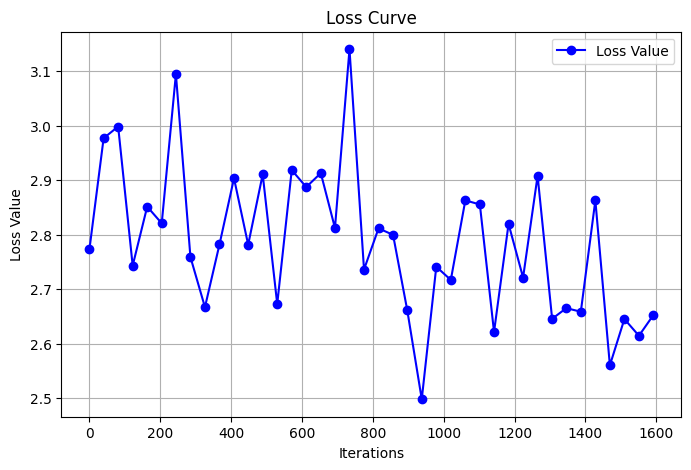

In [13]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = sk_loss_mcar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

